### Sliding window of 30 minutes, with data that has been prefiltered with a lowpass of 0.01667 Hz (1 min)

#### Perhaps surpisingly, this didn't work very well. Fits for the temperature and soil moisture datasets are worse than in the case
#### of non-filtered data

In [116]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [166]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [167]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_30/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-18]
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

In [168]:
lineCSN_M3['TTime'] = lineCSN_M3.index
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

2016-08-05T18:07:38.000000Z


In [169]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

In [170]:
def extract_mean_over_channels(indf,channels_to_drop):
    
    '''Takes an input dataframe, calculates the mean over columns that are not in the list 
    "channels_to_drop". Returns mean dataframe
    '''
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1))
    opdf.columns = ['time',newcolname]
    
    return opdf

In [171]:
channels_to_drop = ['time']
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

In [172]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))  
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [173]:
cleaned_df = merged_df.dropna()

In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [186]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [188]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [189]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.09772121 0.04488415 0.08709637 0.01663596 0.0730811  0.08337205
 0.07597636 0.08013809 0.10282393 0.03989802 0.12442831 0.04309557
 0.02388847 0.01535778 0.07606852 0.0155341 ]
0.43909505083622213


In [190]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.12442831474464251 mean_x_crossing_m_rms_fc
0.10282393219320858 mean_median_rms_fc
0.09772121266578719 mean_mean_rms_fc
0.08709637424782986 mean_peak_welch_rms_fc
0.08337204793379077 mean_interquartile_range_rms_fc


In [191]:
regr.score(X_test,y_test)

0.43623419346372816

In [205]:
outliers_y = []
outliers_x = []
X_test_indices = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices.append(X_test.index[i])
    i += 1

In [206]:
regr_pred = regr.predict(X_test)

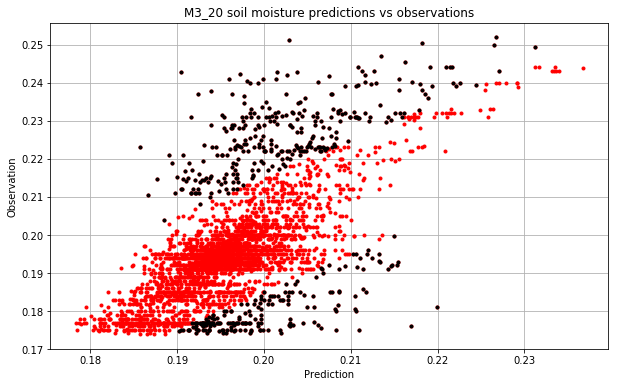

In [207]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

#### Same proceedure with the temperature dataset

In [214]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [215]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.1023042  0.03175899 0.11065083 0.01222263 0.08224488 0.06682355
 0.05734758 0.0493142  0.09883513 0.03181865 0.23723404 0.02349621
 0.01754691 0.01216399 0.05440668 0.01183152]
0.6095858411106303


In [216]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.23723404071919632 mean_x_crossing_m_rms_fc
0.11065082926736788 mean_peak_welch_rms_fc
0.10230419648130659 mean_mean_rms_fc
0.09883513381501456 mean_median_rms_fc
0.08224488371812542 mean_kurtosis_rms_fc


In [217]:
regr.score(X_test,y_test)

0.5999466884456031

In [221]:
regr_pred = regr.predict(X_test)

In [224]:
outliers_y = []
outliers_x = []
X_test_indices = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 4:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices.append(X_test.index[i])
    i += 1

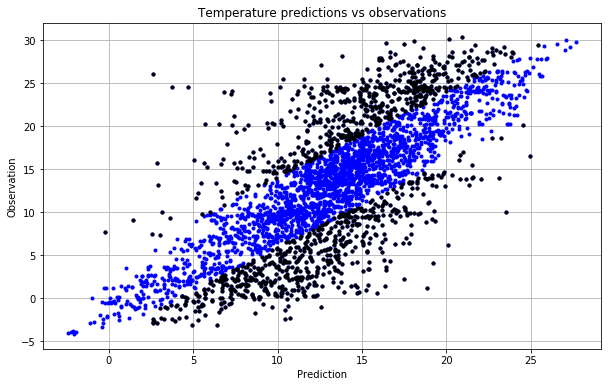

In [225]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

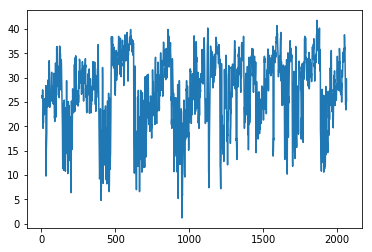

In [50]:
X['mean_x_crossing_m_rms_fc'][:2000].plot()

#### Attempt to understand the gappy nature of this dataset

In [146]:
ser_diff = pd.to_datetime(cleaned_df['time']).diff()

In [147]:
cleaned_df['diffs'] = ser_diff

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [148]:
step_indices = np.array(cleaned_df[cleaned_df['diffs'] != "00:05:00"].index)

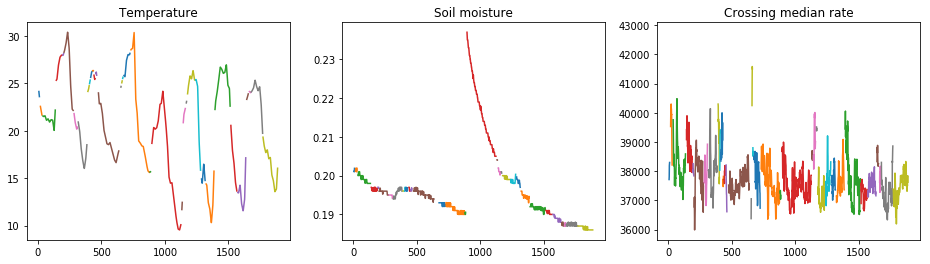

In [154]:
#This is going to break the timeseries into continuous chunks. 
#We might want to filter these chunks individually and then put the the timeseries back together

#We have many small gaps in the data, caused by the despiking filter - could interpolate over thes 
#Large gaps of several hours are more difficult to deal with

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(len(step_indices)-1):
    start_index = step_indices[i]+1
    end_index = step_indices[i+1]-1
    part_df = cleaned_df.loc[start_index:end_index]
    try:
        part_df['Temphigh_interp'].plot(ax=ax1,title='Temperature')
        part_df['M3_20_Avg_interp'].plot(ax=ax2,title='Soil moisture')
        part_df['mean_x_crossing_m_rms_fc'].plot(ax=ax3,title='Crossing median rate')
    except:
        continue
    if i > 40:
        break